In [51]:
import bnpy
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

FIG_SIZE = (14, 2)
plt.rcParams['figure.figsize'] = FIG_SIZE

# dataset_path = os.path.join('..', 'data')
# all_data = bnpy.data.XData.read_csv(os.path.join(dataset_path, 'anomaly0245.csv'))

In [52]:
%qtconsole

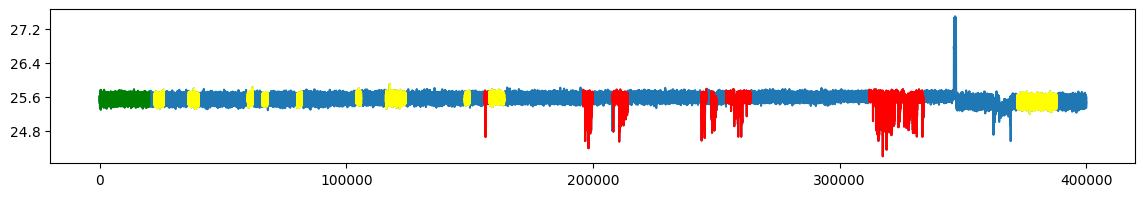

In [53]:
data_start = 0
data_init_size = 20000
batch_size = 2000
batchnum = int(data_init_size/batch_size)
anomalies = [78, 98, 99, 104, 105, 106, 122, 124, 127, 128, 129, 130, 131, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166]
cleans = [11, 12, 18, 19, 30, 33, 40, 52, 58, 59, 60, 61, 74, 79, 80, 81, 186, 187, 188, 189, 190, 191, 192, 193]

all_data = pd.read_csv('/home/torenvln/git/bnp-anomaly/data/anomaly0245.csv')
all_data.drop(all_data.columns[0], inplace=True, axis=1)

init_data = all_data.head(data_init_size)
init_data = bnpy.data.XData.from_dataframe(init_data)

batches = []
i = 0 
while i < len(all_data)- batch_size:
    batches.append(bnpy.data.XData.from_dataframe(all_data.iloc[i:i + batch_size]))
    i += batch_size

plt.plot(all_data)
plt.plot(init_data.X, c='green')
for i in anomalies:
    plt.plot(list(range(i * batch_size, i * batch_size + batch_size)), batches[i].X, c='red')
for i in cleans:
    plt.plot(list(range(i * batch_size, i * batch_size + batch_size)), batches[i].X, c='yellow')
plt.show()

In [18]:
###############################################################################
#
# *DiagGauss* observation model
# --------------------------------------------
#

gamma = 1.0
sF = 1.0
K = 10  # Initialize K component

trained_model, info_dict = bnpy.run(
    init_data, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=f'/tmp/faithful/trymoves-K={K}-gamma={gamma}-lik=DiagGauss-ECovMat={sF}*eye-moves=none/',
    nLap=1000, nTask=1, nBatch=batchnum, convergeThr=0.0001,
    gamma0=gamma, sF=sF, ECovMat='eye',
    moves='birth,merge,delete,shuffle',
    K=K, initname='randexamplesbydist', ts=True)

  --ts
Dataset Summary:
X Data
  total size: 20000 units
  batch size: 2000 units
  num. batches: 10
Allocation Model:  DP mixture with K=0. Concentration gamma0= 1.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 3 
  beta = [ 1] 
  Expectations
  E[  mean[k]] = 
  [ 0]
  E[ covar[k]] = 
  [[1.]]
Initialization:
  initname = randexamplesbydist
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=10-gamma=1.0-lik=DiagGauss-ECovMat=1.0*eye-moves=none/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    0.100/1000 after      1 sec. |    460.3 MiB | K   10 | loss -9.668657

# New Operations  

- Only done on replacing the batchSS.
- There are SS specific copy operations, find out and used them  
- [] Figure out calculation of propXSS which is needed for anomaly detection.

In [19]:
# Get the learned SS from model and info dict
S_k0 = copy.deepcopy(info_dict["SS"])  # This is the S_k0, sufficient statistics of the component of entire dataset
SSmemory = copy.deepcopy(info_dict["SSmemory"])  # Dictionary of SS for all batches

In [20]:
vars(trained_model.obsModel.Post)

{'K': 1,
 'D': 1,
 '_FieldDims': {'nu': 'K', 'kappa': 'K', 'm': ('K', 'D'), 'beta': ('K', 'D')},
 'doCollapseK1': False,
 'nu': array([20003.]),
 'kappa': array([20000.0001]),
 'm': array([[25.54308909]]),
 'beta': array([[59.53989048]])}

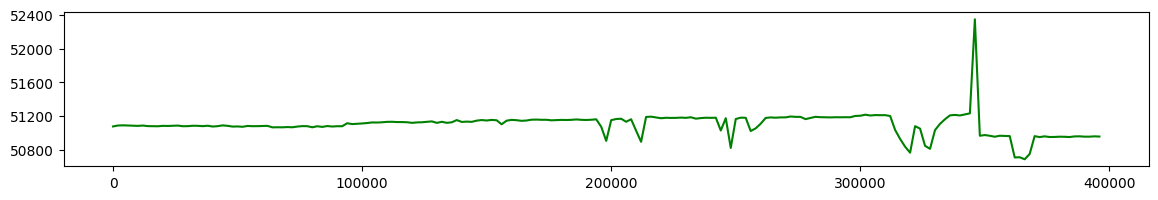

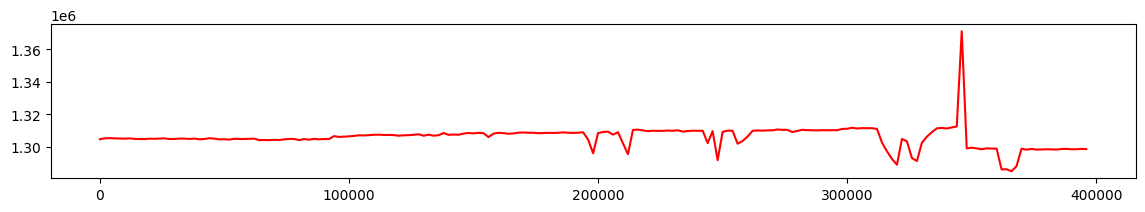

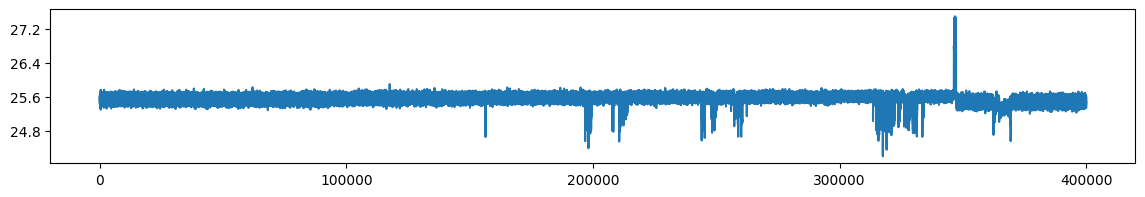

In [50]:
LPanomaly = []
SSanomaly = []
for batch in batches:
    LP = trained_model.calc_local_params(batch)
    LPanomaly.append(LP)  # Calculation of responsibility, needed for next step
    SSanomaly.append(trained_model.get_global_suff_stats(batch, LP))  # Calculation of SS for new data

N = []
K = []
x = []
xx = []
beta = []
for key in SSanomaly:
    N.append(key.N)
    K.append(key.K)
    x.append(key.x)
    xx.append(key.xx)
x = np.vstack(x)
xx = np.vstack(xx)

index = list(range(0, len(x)))
index = [el * batch_size for el in index]
plt.plot(index, x, c='green')
plt.show()
plt.plot(index, xx, c='red')
plt.show()
plt.plot(all_data)
plt.show()